In [1]:
dataset_name = "art_daily_flatmiddle"
path = "data/" + dataset_name + ".csv"
gaussian_window_size = 1024

In [2]:
import adclasses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import math
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Preprocess dataset

In [3]:
data = pd.read_csv(path, header=0)
start_date = data["timestamp"].values[0]
end_date = data["timestamp"].values[-1]
print("Start date: ", start_date)
print("End date: ", end_date)

data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

print("Missing time stamps: \n", adclasses.find_missing_time_steps(start_date, end_date, 
                                                                   '5min', data))

# write to csv for htm
# data.to_csv("/home/cfreeman/Desktop/prefill/" + dataset_name + ".csv", index=False)

ad = adclasses.UnivariateAnomalyDetection(dataframe=data, 
                                          timestep="5min", 
                                          dateformat="%Y-%m-%d %H:%M:%S", 
                                          name=dataset_name)
print("Length: ", ad.get_length())
print("Time step size: ", ad.get_timestep())
print("Start Date: ", start_date)
print("End Date: ", end_date)
print("Date Format: ", ad.get_dateformat())
true_outlier_dates = ["2014-04-11 00:00:00"]
true_outlier_indices = ad.convert_true_outlier_date(true_outlier_dates)
print("True outlier indices: ", true_outlier_indices)

Start date:  2014-04-01 00:00:00
End date:  2014-04-14 23:55:00
Missing time stamps: 
 DatetimeIndex([], dtype='datetime64[ns]', freq='5T')
Length:  4032
Time step size:  5min
Start Date:  2014-04-01 00:00:00
End Date:  2014-04-14 23:55:00
Date Format:  %Y-%m-%d %H:%M:%S
True outlier indices:  [2880]


# windowed gaussian

In [4]:
# optimization step
step_sizes = [100, 200, 300, 400, 500]

opt_dict = {}

for step_size in step_sizes:
    print("Step size: ", step_size)
    output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                       step_size = step_size, 
                                       optimize=True,
                                       plot_anomaly_score=False)
    print("MSE: ", output_dict["MSE"])
    opt_dict[step_size] = output_dict["MSE"]

best_step_size = min(opt_dict, key=opt_dict.get)
print("\nbest step size: ", best_step_size)

Step size:  100
MSE:  2148.1232807801493
Step size:  200
MSE:  2148.1232807801493
Step size:  300
MSE:  2148.1232807801493
Step size:  400
MSE:  2148.1232807801493
Step size:  500
MSE:  2148.1232807801493

best step size:  100


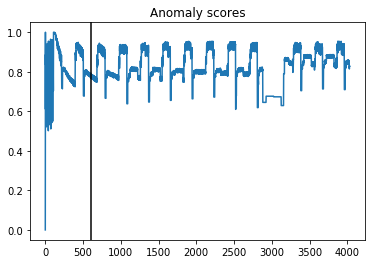

Time:  0.20245909690856934


['anomaly_scores/windowed_gaussian/art_daily_flatmiddle']

In [5]:
save_path = "anomaly_scores/windowed_gaussian/" + dataset_name

output_dict = ad.windowed_gaussian(gaussian_window_size=gaussian_window_size, 
                                   step_size = best_step_size, 
                                   plot_anomaly_score=True)

print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# SARIMA: using autoarima


 Fitting models using approximations to speed things up...

 ARIMA(2,0,2) with non-zero mean : 2915.911
 ARIMA(0,0,0) with non-zero mean : 2938.353
 ARIMA(1,0,0) with non-zero mean : 2941.423
 ARIMA(0,0,1) with non-zero mean : 2940.598
 ARIMA(0,0,0) with zero mean     : 2936.166
 ARIMA(1,0,2) with non-zero mean : 2914.01
 ARIMA(0,0,2) with non-zero mean : 2931.126
 ARIMA(1,0,1) with non-zero mean : 2943.677
 ARIMA(1,0,3) with non-zero mean : 2916.151
 ARIMA(0,0,3) with non-zero mean : 2931.058
 ARIMA(2,0,1) with non-zero mean : 2914.818
 ARIMA(2,0,3) with non-zero mean : 2917.994
 ARIMA(1,0,2) with zero mean     : 2912.411
 ARIMA(0,0,2) with zero mean     : 2929.338
 ARIMA(1,0,1) with zero mean     : 2941.469
 ARIMA(2,0,2) with zero mean     : 2914.551
 ARIMA(1,0,3) with zero mean     : 2914.597
 ARIMA(0,0,1) with zero mean     : 2938.403
 ARIMA(0,0,3) with zero mean     : 2929.278
 ARIMA(2,0,1) with zero mean     : 2913.166
 ARIMA(2,0,3) with zero mean     : 2916.588

 Now re-fitting

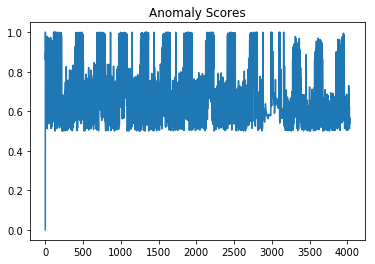

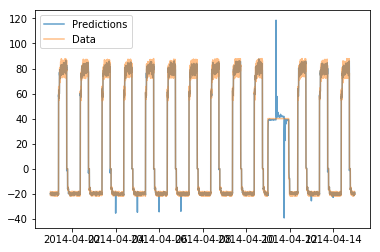

Time:  12.309821367263794


['anomaly_scores/SARIMA_auto/art_daily_flatmiddle']

In [6]:
save_path = "anomaly_scores/SARIMA_auto/" + dataset_name
output_dict = ad.sarimax(gaussian_window_size=gaussian_window_size, step_size=100, auto=True,
                         use_exog=True, plot_anomaly_scores=True,plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# Facebook Prophet

In [7]:
# optimization step

step_sizes = [100, 200, 300, 400, 500]
changepoint_prior_scales = [.01, .05, .1, .15, .2]
opt_dict = {}

for step_size in step_sizes:
    for changepoint_prior_scale in changepoint_prior_scales:

        mse = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  changepoint_prior_scale=changepoint_prior_scale,
                                  step_size=step_size,
                                  optimize=True)
        print("Step Size: ", step_size)
        print("Changepoint Prior Scale: ", changepoint_prior_scale)
        print("MSE: ",mse)

        key_str = "Step Size " + str(step_size) +" Changepoint Prior Scale" + str(changepoint_prior_scale)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.01
MSE:  129.28998670705568


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.05
MSE:  128.67379457495267


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.1
MSE:  128.59854960316548


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.15
MSE:  128.59543623496702


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  100
Changepoint Prior Scale:  0.2
MSE:  128.58575816722671


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.01
MSE:  129.28998670705568


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.05
MSE:  128.67379457495267


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.1
MSE:  128.59854960316548


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.15
MSE:  128.59543623496702


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  200
Changepoint Prior Scale:  0.2
MSE:  128.58575816722671


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  300
Changepoint Prior Scale:  0.01
MSE:  129.28998670705568


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  300
Changepoint Prior Scale:  0.05
MSE:  128.67379457495267


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  300
Changepoint Prior Scale:  0.1
MSE:  128.59854960316548


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  300
Changepoint Prior Scale:  0.15
MSE:  128.59543623496702


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  300
Changepoint Prior Scale:  0.2
MSE:  128.58575816722671


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  400
Changepoint Prior Scale:  0.01
MSE:  129.28998670705568


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  400
Changepoint Prior Scale:  0.05
MSE:  128.67379457495267


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  400
Changepoint Prior Scale:  0.1
MSE:  128.59854960316548


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  400
Changepoint Prior Scale:  0.15
MSE:  128.59543623496702


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  400
Changepoint Prior Scale:  0.2
MSE:  128.58575816722671


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  500
Changepoint Prior Scale:  0.01
MSE:  129.28998670705568


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  500
Changepoint Prior Scale:  0.05
MSE:  128.67379457495267


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  500
Changepoint Prior Scale:  0.1
MSE:  128.59854960316548


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Step Size:  500
Changepoint Prior Scale:  0.15
MSE:  128.59543623496702
Step Size:  500
Changepoint Prior Scale:  0.2
MSE:  128.58575816722671

best params:  Step Size 100 Changepoint Prior Scale0.2


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


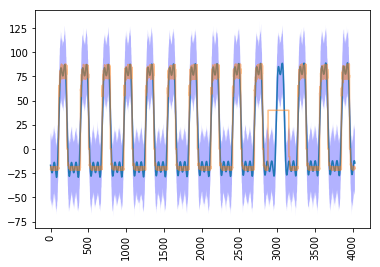

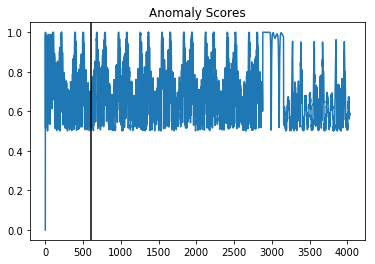

Time:  29.90865921974182


['anomaly_scores/Prophet/art_daily_flatmiddle']

In [8]:
save_path = "anomaly_scores/Prophet/" + dataset_name
output_dict = ad.facebook_prophet(gaussian_window_size=gaussian_window_size, 
                                  changepoint_prior_scale=.2,
                                  step_size=100,
                                  plot_forecast=True,
                                  plot_anomaly_score=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)

# HTM

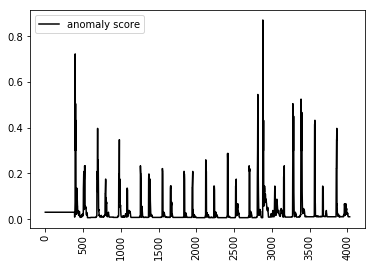

Time:  27.41


['anomaly_scores/HTM/art_daily_flatmiddle']

In [9]:
htm_results_path = "htm_studio_results/" + "htm_results_" + dataset_name + "_value.csv"
htm_results = pd.read_csv(htm_results_path, header=0)

plt.plot(htm_results["raw_anomaly_score"], color="black", label="anomaly score")
plt.legend()
plt.xticks(rotation=90)
plt.show()

anomaly_scores = np.nan_to_num(htm_results["raw_anomaly_score"].values)

save_path = "anomaly_scores/HTM/" + dataset_name
print("Time: ", "27.41")
output_dict = {"Anomaly Scores": anomaly_scores, "Time": "27.41"}
joblib.dump(output_dict, save_path)

# HOTSAX

In [10]:
# only need one window size
# save_path = "anomaly_scores/hotsax/" + dataset_name
# output_dict = ad.hotsax(win_size=50, num_discords=int((.2/100) * ad.get_length()),
#                a_size=3, paa_size=3, z_threshold=0.01,
#                plot_anomaly_score=True)
# print("Time: ", output_dict["Time"])
# joblib.dump(output_dict, save_path)

# GLM

In [11]:
# optimize
etas = [.5,1]
lambdas = [.99, .999, .9999]

opt_dict = {}

for eta in etas:
    for lambda_ in lambdas:
       
        mse = ad.glm(gaussian_window_size=gaussian_window_size, 
                     family='gaussian', 
                     eta=eta, 
                     lambda_=lambda_)["MSE"]

        print("eta: ", eta)
        print("lambda: ", lambda_)
        print("MSE: ",mse)

        key_str = "eta " + str(eta) + " lambda " + str(lambda_)

        opt_dict[key_str] = mse

best_params = min(opt_dict, key=opt_dict.get)
print("\nbest params: ", best_params)

  0%|          | 0/4032 [00:00<?, ?it/s]

Initial Mean 15.744722956066381
Initial StdDev 46.280758814123985


100%|██████████| 4032/4032 [00:00<00:00, 28137.98it/s]

eta:  0.5
lambda:  0.99
MSE:  5.6923401155798375e+25
Initial Mean 15.744722956066381
Initial StdDev 46.280758814123985



 37%|███▋      | 1487/4032 [00:00<00:00, 14864.63it/s]

eta:  0.5
lambda:  0.999
MSE:  218.4476694929914
Initial Mean 15.744722956066381
Initial StdDev 46.280758814123985


 35%|███▌      | 1426/4032 [00:00<00:00, 14253.56it/s]

eta:  0.5
lambda:  0.9999
MSE:  244.88909811376735
Initial Mean 15.744722956066381
Initial StdDev 46.280758814123985


 38%|███▊      | 1552/4032 [00:00<00:00, 15218.75it/s]

eta:  1
lambda:  0.99
MSE:  26004258.076104634
Initial Mean 15.744722956066381
Initial StdDev 46.280758814123985


 46%|████▌     | 1859/4032 [00:00<00:00, 18584.66it/s]

eta:  1
lambda:  0.999
MSE:  160.85860258142787
Initial Mean 15.744722956066381
Initial StdDev 46.280758814123985


100%|██████████| 4032/4032 [00:00<00:00, 18264.94it/s]


eta:  1
lambda:  0.9999
MSE:  182.64436252769772

best params:  eta 1 lambda 0.999


 46%|████▌     | 1843/4032 [00:00<00:00, 18425.36it/s]

Initial Mean 15.744722956066381
Initial StdDev 46.280758814123985


100%|██████████| 4032/4032 [00:00<00:00, 17849.29it/s]


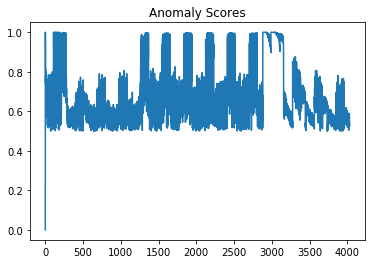

Time:  1.103238582611084


['anomaly_scores/GLM/art_daily_flatmiddle']

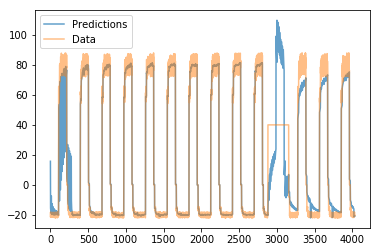

In [12]:
save_path = "anomaly_scores/GLM/" + dataset_name
output_dict = ad.glm(gaussian_window_size=gaussian_window_size, family='gaussian', 
                     eta=int(best_params[4:6]),
                     lambda_=float(best_params[14:]),
                     plot_anomaly_scores=True, plot_forecast=True)
print("Time: ", output_dict["Time"])
joblib.dump(output_dict, save_path)


In [13]:
# no twitter bc no seasonality
# no stl resid bc no seasonality
# no Anomalous bc no seasonality